# UNFINISHED - Multi-task learning

Can we fit a model to multiple targets to improve performance on a tabular learning example?

Todo:
1. Download data and process
   1. Weather dataset - https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data?resource=download
      1. Predict the temperature in one city based on its historic weather
      2. Predict the temperature of multiple cities at once
      3. Predict multiple weather signals in one/multiple cities
   2. Retail dataset
2. Build base learners
   1. GBM
   2. Dense neural network
3. Build multi task learners
   1. Shared layers, with split layers per task
4. Explore the combination of metrics

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import polars as pl

plt.style.use("seaborn-v0_8-whitegrid")
pl.Config.set_fmt_str_lengths(30)

polars.config.Config

## Load data

In [2]:
df = pl.read_csv("data/weather/temperature.csv")
df = df.with_columns(
    pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"),
    pl.exclude("datetime") - 273.15,  # convert from Kelvin to Celcius
)
display(df.shape, df.head())

df.describe()

(45253, 37)

datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,San Antonio,Dallas,Houston,Kansas City,Minneapolis,Saint Louis,Chicago,Nashville,Indianapolis,Atlanta,Detroit,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2012-10-01 12:00:00,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,35.95,null,null,null
2012-10-01 13:00:00,11.48,8.93,16.33,8.65,18.72,18.38,20.26,23.45,11.97,11.46,16.14,16.59,15.12,16.83,13.72,13.03,10.86,14.26,10.7,20.88,10.88,25.02,15.5,26.57,7.85,13.11,12.48,15.07,12.68,14.02,34.44,32.32,37.43,31.25,31.25,30.35
2012-10-01 14:00:00,11.479041,8.933252,16.324993,8.647217,18.718186,18.383501,20.253141,23.458509,12.004558,11.457306,16.153649,16.612974,15.147576,16.847635,13.743636,13.035246,10.904691,14.27136,10.739394,20.885341,10.919789,25.05523,15.500172,26.582518,7.874767,13.112541,12.513208,15.097676,12.68465,14.036092,34.44,31.16,37.345769,31.25,31.25,30.35
2012-10-01 15:00:00,11.476998,8.941866,16.310618,8.639833,18.712844,18.393355,20.242177,23.481487,12.083952,11.449918,16.188497,16.680767,15.184343,16.888151,13.801401,13.049194,11.027412,14.304637,10.791919,20.899702,11.023965,25.149595,15.500582,26.616579,7.938319,13.119518,12.606824,15.17694,12.69779,14.081672,34.241513,31.131841,37.261538,31.25,31.25,30.35
2012-10-01 16:00:00,11.474955,8.950481,16.296243,8.632449,18.707503,18.403209,20.231213,23.504466,12.163345,11.44253,16.223345,16.74856,15.221111,16.928666,13.859166,13.063142,11.150133,14.337914,10.844444,20.914063,11.12814,25.243961,15.500991,26.650641,8.00187,13.126496,12.70044,15.256203,12.710929,14.127251,33.9952,31.088015,37.177308,31.25,31.25,30.35


statistic,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,San Antonio,Dallas,Houston,Kansas City,Minneapolis,Saint Louis,Chicago,Nashville,Indianapolis,Atlanta,Detroit,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""45253""",44458.0,45252.0,44460.0,45250.0,45250.0,45252.0,45252.0,45250.0,45252.0,45252.0,45252.0,45249.0,45250.0,45252.0,45240.0,45252.0,45250.0,45251.0,45246.0,45247.0,45252.0,45252.0,45250.0,44448.0,45250.0,45252.0,45250.0,44460.0,45250.0,45250.0,44455.0,44460.0,44461.0,44455.0,44456.0,44460.0
"""null_count""","""0""",795.0,1.0,793.0,3.0,3.0,1.0,1.0,3.0,1.0,1.0,1.0,4.0,3.0,1.0,13.0,1.0,3.0,2.0,7.0,6.0,1.0,1.0,3.0,805.0,3.0,1.0,3.0,793.0,3.0,3.0,798.0,793.0,792.0,798.0,797.0,793.0
"""mean""","""2015-05-02 06:00:00""",10.712654,11.842929,15.005821,11.259626,17.696116,17.065044,19.274887,22.343358,12.467856,9.689407,20.635646,19.225872,21.054268,13.491663,7.550489,13.525947,10.200573,15.416306,11.621904,16.622673,9.821668,21.18338,15.747483,25.031274,10.903939,8.791241,12.224168,12.250406,7.19301,10.629823,18.371986,21.362307,23.347276,22.116398,20.944803,20.034253
"""std""",null,6.640131,7.452438,5.332862,6.547986,6.460823,5.889992,10.829522,9.916743,9.853484,10.673464,8.303688,9.464741,7.766719,11.169761,12.774979,10.938867,10.997137,9.88359,11.043634,8.703643,11.034481,6.682162,9.133072,4.190185,10.453927,10.547226,10.242377,10.220932,11.953626,9.802499,7.821815,6.676412,8.852984,6.324566,6.304118,7.093583
"""min""","""2012-10-01 12:00:00""",-28.0,-10.78,-0.85,-9.37,-6.646333,-7.366667,-12.588667,-7.091,-18.107667,-25.422333,-8.1,-11.539667,-5.58,-23.593667,-30.813333,-22.1,-24.26,-16.823667,-28.283667,-13.65,-29.666667,-4.54,-17.491667,2.083333,-23.727333,-25.85,-22.76,-22.376,-29.85,-23.61,-0.971,-2.101,-2.0,-2.0,-4.468,-0.176
"""25%""","""2014-01-15 21:00:00""",6.01,6.7,11.52,6.68,13.23,13.105,10.77,14.53,4.82,1.91,15.45,12.57,16.211,5.15,-1.36,5.11,2.022333,8.07,2.96,10.1705,1.54,16.891,8.86,22.88,2.707014,1.11,4.200348,4.22,-1.18,2.94,12.217246,16.3,16.584,17.317333,16.732,14.374304
"""50%""","""2015-05-02 06:00:00""",10.3,11.17,14.46,10.79,17.38,16.97,18.879973,22.437667,12.97,9.821333,22.035,20.413,22.51,14.912,8.489,14.6195,10.791,16.820333,12.78,17.9,10.39,22.49,16.97,25.73,12.07,9.2,12.777667,12.72,7.959,10.984,17.782667,21.75,23.0,21.67,21.0,19.8465
"""75%""","""2016-08-15 15:00:00""",15.451047,16.3,17.864667,15.38,21.93,20.9575,27.684667,29.9,19.685357,17.53,26.34,26.4,26.54,22.48,18.16,22.41,19.13,22.9905,20.81,23.14,19.08,25.99,22.62,27.842333,19.43,17.509333,20.646,20.61,17.22,18.47,24.12,26.65,30.0,26.51,25.78,26.0
"""max""","""2017-11-30 00:00:00""",33.85,39.37,40.47,34.15,42.32,40.21,45.49,48.07,39.56,40.6,40.51,41.25,39.76,37.82,35.09,38.44,35.33,36.0,38.89,37.61,34.9,37.0,37.75,35.53,33.14,34.13,34.85,37.09,34.73,34.85,41.67,47.78,47.0,47.78,40.0,43.89


## Exploring data

One city

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_80708/145513604.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


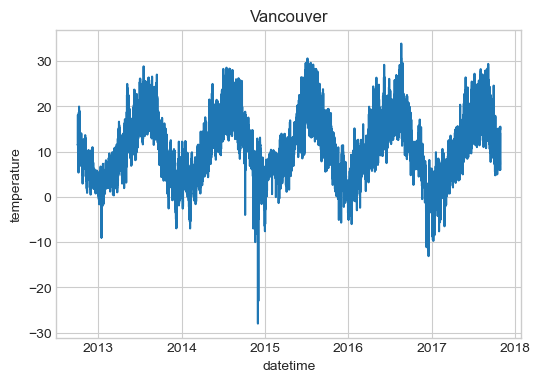

In [3]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=df.to_pandas(), x="datetime", y="Vancouver", ax=ax)
ax.set(title="Vancouver", ylabel="temperature")
fig.show()

Multiple cities, plotting per day

We see correlation between cities, therefore we should be able to learn these in combination.

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_80708/987674945.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


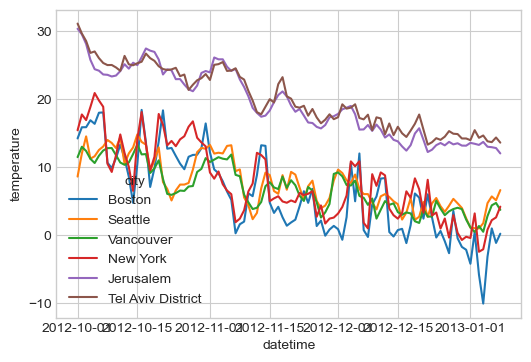

In [4]:
plot_df = (
    df.with_columns(pl.col("datetime").dt.date())
    .select(
        [
            "datetime",
            "Boston",
            "Seattle",
            "Vancouver",
            "New York",
            "Jerusalem",
            "Tel Aviv District",
        ]
    )
    .group_by("datetime")
    .mean()
    .sort("datetime")
    .head(100)
    .melt(id_vars=["datetime"], variable_name="city", value_name="temperature")
)
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=plot_df.to_pandas(), x="datetime", y="temperature", hue="city", ax=ax)
fig.show()

## Building models

In [5]:
df_train = df[: int(df.shape[0] * 0.75)]
df_test = df[int(df.shape[0] * 0.75) :]

df_train.shape, df_test.shape

((33939, 37), (11314, 37))

Feature setup

Predict 24 hours ahead, given various lags of the same time series.

In [6]:
def create_lag_features(df, value_col, lags):
    for lag in lags:
        df = df.with_columns(
            pl.col(value_col).shift(lag).alias(f"{value_col}_lag_{lag}")
        )
    return df


def filter_null_rows(df):
    return df.filter(pl.any_horizontal(pl.all().is_null()).not_())


def process(df, cities):
    lags = [24, 24 * 2, 24 * 3, 24 * 7]
    df = pl.concat(
        [df.select("datetime")]
        + [create_lag_features(df.select(city), city, lags) for city in cities],
        how="horizontal",
    )
    df = filter_null_rows(df)
    return df


outcome_cols = ["Vancouver"]
df_train_proc = process(df_train, outcome_cols)
df_test_proc = process(df_test, outcome_cols)
feature_cols = [col for col in df_train_proc.columns if "_lag_" in col]
df_train_proc.head()

datetime,Vancouver,Vancouver_lag_24,Vancouver_lag_48,Vancouver_lag_72,Vancouver_lag_168
datetime[μs],f64,f64,f64,f64,f64
2012-10-08 13:00:00,8.99,7.31,7.03,5.42,11.48
2012-10-08 14:00:00,7.73,7.14,6.49,5.36,11.479041
2012-10-08 15:00:00,7.56,7.61,6.39,5.76,11.476998
2012-10-08 16:00:00,10.87,10.32,8.22,8.71,11.474955
2012-10-08 17:00:00,12.19,12.47,11.33,9.63,11.472911


### Univariate model


Predict the weather given historic weather events.
We can track seasonal trends like the month of the year, hour of the day and a long term trend.

We will just use dense networks instead of time series specific layers.

In [7]:
import pytorch_lightning as pyl
from typing import List
import torch
import torch.nn as nn


class SimpleMLP(pyl.LightningModule):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: List[int] = None,
        output_dim: int = 1,
        learning_rate=1e-3,
    ):
        super().__init__()

        if hidden_dim is None:
            hidden_dim = [32, 16, 16, 16]

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[2]),
            nn.ReLU(),
            nn.Linear(hidden_dim[2], hidden_dim[3]),
            nn.ReLU(),
            nn.Linear(hidden_dim[3], output_dim),
        )

        self.loss = nn.MSELoss()
        self.log_train = []
        self.log_val = []
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.net(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_est = self.forward(x)
        loss = self.loss(y, y_est)

        self.log("train_loss", loss, prog_bar=True, on_step=True)
        self.log_train.append(loss.detach().cpu().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_est = self.forward(x)
        loss = self.loss(y, y_est)

        self.log("val_loss", loss, prog_bar=True, on_step=True)
        self.log_val.append(loss.cpu().numpy())
        return loss

/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
def dataloader_from_df(df, feature_cols, outcome_cols):
    dataset = torch.utils.data.TensorDataset(
        torch.Tensor(df[feature_cols].to_numpy()),
        torch.Tensor(df[outcome_cols].to_numpy()),
    )
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=2**10, shuffle=True)
    return dataloader


dataloader_train = dataloader_from_df(df_train_proc, feature_cols, outcome_cols)
dataloader_test = dataloader_from_df(df_test_proc, feature_cols, outcome_cols)
data_batch = next(iter(dataloader_train))
data_batch[0]

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_80708/3233260824.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  torch.Tensor(df[outcome_cols].to_numpy()),


tensor([[12.5700,  9.6600, 12.9000, 15.0200],
        [19.2200, 17.9000, 18.6400,  9.8600],
        [13.7000, 13.1500, 15.0900, 17.7980],
        ...,
        [11.5300,  9.8200,  9.9400,  9.7200],
        [ 5.6700,  4.8400,  4.9900, 10.7135],
        [18.3300, 21.0200, 19.0600, 16.1500]])

In [9]:
torch.manual_seed(1)
model = SimpleMLP(input_dim=len(feature_cols), output_dim=len(outcome_cols), learning_rate=1e-3)
data_batch = next(iter(dataloader_train))
data_batch[0]
model(data_batch[0])

tensor([[-0.1540],
        [-0.1226],
        [-0.1336],
        ...,
        [-0.1511],
        [-0.1265],
        [-0.1072]], grad_fn=<AddmmBackward0>)

In [10]:
trainer = pyl.Trainer(max_epochs=10, accelerator="mps")
trainer.fit(model, dataloader_train)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.2 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_worke

Epoch 9: 100%|██████████| 33/33 [00:00<00:00, 100.66it/s, v_num=34, train_loss=4.060]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 33/33 [00:00<00:00, 97.76it/s, v_num=34, train_loss=4.060] 


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_80708/1383254041.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


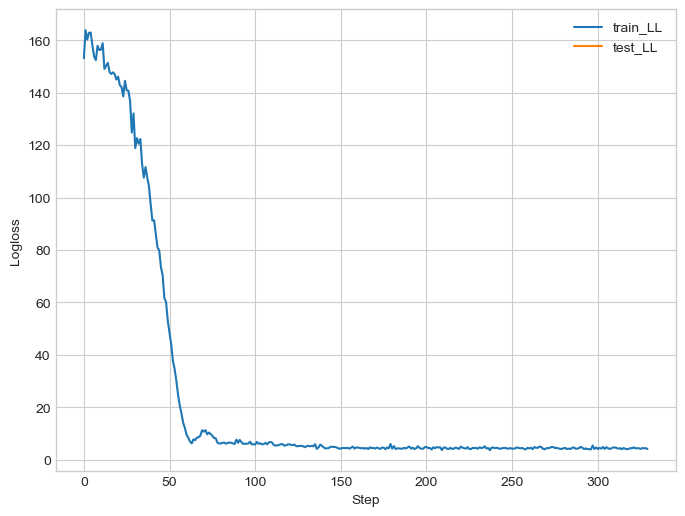

In [11]:
def plot_training_logs(model):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(np.array(model.log_train), label="train_LL")
    ax.plot(np.array(model.log_val), label="test_LL")
    ax.set(xlabel="Step", ylabel="Logloss")
    ax.legend()
    fig.show()


plot_training_logs(model)


Overall loss

In [12]:
y_est_y = torch.concat([torch.concat([model(x), y], dim=1) for x, y in dataloader_train])
print(nn.MSELoss()(y_est_y[:,0], y_est_y[:,1]).detach())

y_est_y = torch.concat([torch.concat([model(x), y], dim=1) for x, y in dataloader_test])
print(nn.MSELoss()(y_est_y[:,0], y_est_y[:,1]).detach())


tensor(4.3688)
tensor(4.9156)


Adding another output, does it improve loss on the first outcome?

In [13]:
def loss_from_outcomes(outcome_cols, debug:bool=False):
    df_train_proc = process(df_train, outcome_cols)
    df_test_proc = process(df_test, outcome_cols)
    feature_cols = [col for col in df_train_proc.columns if "_lag_" in col]

    torch.manual_seed(1)
    dataloader_train = dataloader_from_df(df_train_proc, feature_cols, outcome_cols)
    dataloader_test = dataloader_from_df(df_test_proc, feature_cols, outcome_cols)

    model = SimpleMLP(
        input_dim=len(feature_cols),
        output_dim=len(outcome_cols),
        learning_rate=1e-3,
    )
    trainer = pyl.Trainer(max_epochs=10, accelerator="mps", enable_progress_bar=debug)
    trainer.fit(model, dataloader_train)

    if debug:
        plot_training_logs(model)

    y_est_y = torch.concat(
        [torch.concat([model(x), y], dim=1) for x, y in dataloader_train]
    )
    loss_train = nn.MSELoss()(y_est_y[:, 0], y_est_y[:, 1]).detach()

    y_est_y = torch.concat(
        [torch.concat([model(x), y], dim=1) for x, y in dataloader_test]
    )
    loss_test = nn.MSELoss()(y_est_y[:, 0], y_est_y[:, 1]).detach()
    return loss_train, loss_test

In [18]:
city_groups = [
    ["Vancouver"],
    ["Vancouver", "Boston"],
    [
        "Vancouver",
        "Boston",
        "Seattle",
        "New York",
    ],
]
losses = []
for city_group in city_groups:
    loss_train, loss_test = loss_from_outcomes(city_group)
    losses.append(
        {"city_group": city_group, "loss_train": loss_train, "loss_test": loss_test}
    )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.2 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.4 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU av

In [19]:
losses

[{'city_group': ['Vancouver'],
  'loss_train': tensor(4.3745),
  'loss_test': tensor(4.9039)},
 {'city_group': ['Vancouver', 'Boston'],
  'loss_train': tensor(25.0551),
  'loss_test': tensor(19.0307)},
 {'city_group': ['Vancouver', 'Boston', 'Seattle', 'New York'],
  'loss_train': tensor(26.7353),
  'loss_test': tensor(21.8165)}]

## Clustering cities

Distance between cities should relate to their correlation. Clusters nearby cities should optimise their predictions.

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_80708/987674945.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


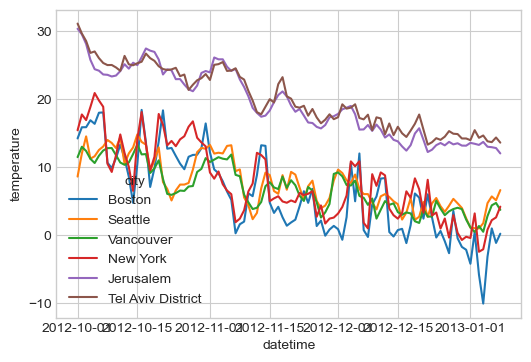

In [16]:
plot_df = (
    df.with_columns(pl.col("datetime").dt.date())
    .select(
        [
            "datetime",
            "Boston",
            "Seattle",
            "Vancouver",
            "New York",
            "Jerusalem",
            "Tel Aviv District",
        ]
    )
    .group_by("datetime")
    .mean()
    .sort("datetime")
    .head(100)
    .melt(id_vars=["datetime"], variable_name="city", value_name="temperature")
)
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=plot_df.to_pandas(), x="datetime", y="temperature", hue="city", ax=ax)
fig.show()

## GBM baseline